In [36]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import scipy as sp
import matplotlib.pyplot as plt


###################################
#### Sparse approach
###################################

def fill_max_sparse_1(input_size):
    max_arr = -np.array([[1, -1], [0, 1], [0, -1]])
    iden = sp.sparse.eye(input_size)
    max_sparse = sp.sparse.bsr_matrix(max_arr)
    matrix = sp.sparse.kron(iden, max_sparse)
    # matrix = np.kron(np.eye(input_size),max_arr)
    # matrix = sp.sparse.bsr_matrix(matrix)
    return matrix.T


def fill_max_sparse_2(input_size):
    array = -sp.sparse.bsr_matrix([1, 1, -1])
    iden = sp.sparse.eye(input_size)
    matrix = np.kron(np.eye(input_size), array)
    matrix = sp.sparse.kron(iden, array)
    return matrix.T


def para_sparse_matrices(*arg):
    result = []
    for mat in zip(*arg):
        sat = sp.sparse.block_diag(mat)
        result.append(sat)
    return result


def shape_to_model(dense_matrix):
    shape_list = [a.shape for a in dense_matrix]
    print(shape_list)
    for i, shap in enumerate(shape_list):
        if i == 0:
            input_mat = tf.keras.Input(shape=(int(shap[0])))
            net = layers.Dense(shap[1], activation="relu", bias_initializer='zeros')(input_mat)
        else:
            net = layers.Dense(shap[1], activation="relu", bias_initializer='zeros')(net)
    model_matrix = tf.keras.Model(input_mat, net)
    mat_init = [b for a in dense_matrix for b in [a.toarray(), np.zeros(a.shape[1])]]
    model_matrix.set_weights(mat_init)
    return model_matrix


def set_up_max_matrix(depth):
    result = []
    while depth != 0:
        result.append(fill_max_sparse_1(depth))
        result.append(fill_max_sparse_2(depth))
        depth = int(depth / 2)
    return result



def fill_min_sparse_1(input_size):
  max_arr = np.array([[-1,1],[0,-1],[0,1]])
  iden = sp.sparse.eye(input_size)
  max_sparse = sp.sparse.bsr_matrix(max_arr)
  matrix = sp.sparse.kron(iden,max_sparse)
  return matrix.T

def fill_min_sparse_2(input_size):
  array = sp.sparse.bsr_matrix([-1,-1,1])
  iden = sp.sparse.eye(input_size)
  matrix = np.kron(np.eye(input_size), array)
  matrix = sp.sparse.kron(iden,array)
  return matrix.T

def set_up_min_matrix(depth):
  result = []
  while depth != 0:
    result.append(fill_min_sparse_1(depth))
    result.append(fill_min_sparse_2(depth))
    depth = int(depth/2)
  return result


def invert_matrix(point_list):
    ones = np.ones((point_list.shape[0],1))
    #print(ones, point_list)
    point_list = np.concatenate((point_list,ones) , axis=1)
    zeros = np.zeros((point_list.shape[0]))
    zeros[0] = 1
    solution = np.linalg.inv(point_list)@zeros
    return solution

In [3]:
point_l = np.array([[2,2],[0,2],[2,0]])
abab = invert_matrix(point_l)

print(abab)

[ 0.5  0.5 -1. ]


In [5]:
xmin=0
xmax=1


x = np.linspace(0,1,9)
grid = np.meshgrid(x,x)

X, Y = np.mgrid[xmin:xmax:9j, xmin:xmax:9j]
positions = np.vstack([X.ravel(), Y.ravel()])

positions = positions.T
dim = positions.shape[0]
ones = np.linspace(0,dim-1,dim).astype(int)

res = pd.DataFrame(positions)
#res = np.column_stack([ones.T,positions])

print(res)

      0      1
0   0.0  0.000
1   0.0  0.125
2   0.0  0.250
3   0.0  0.375
4   0.0  0.500
..  ...    ...
76  1.0  0.500
77  1.0  0.625
78  1.0  0.750
79  1.0  0.875
80  1.0  1.000

[81 rows x 2 columns]


In [4]:
#print(res[res.index==1])
#print(1 in res.iloc[31:32,:].values)
print(res.iloc[3].values)

[0.         0.09677419]


In [5]:
res[res.index==31]

,0,1
31,0.0,1.0


In [6]:
#generate the general patch
def patches(positions):
    result = []
    #result = pd.DataFrame(data=a)
    #result=result.T
    for ind in range(0,dim-1):
        if not( 1 in positions.iloc[ind:ind+1,:].values):
            upper = [ind,ind+1,ind+10]
            lower = [ind,ind+9, ind+10]
            #upper.append([])
            result.append(upper)
            result.append(lower)
    return pd.DataFrame(result)

patch = patches(res)
print(patch)

      0   1   2
0     0   1  10
1     0   9  10
2     1   2  11
3     1  10  11
4     2   3  12
..   ..  ..  ..
123  68  77  78
124  69  70  79
125  69  78  79
126  70  71  80
127  70  79  80

[128 rows x 3 columns]


In [7]:
## generate the nearest neighbours

def neighbour_ind(patches, points):
    list = []
    for ind in points.index:
        obj = []
        for pat in patches.index:
            if (ind in patches.iloc[pat].values):
                obj.append(pat)
        list.append(obj)
    return pd.DataFrame(list)
pat_neighbour = neighbour_ind(patch,res)
print(pat_neighbour)

      0      1      2   3   4   5
0     0    1.0    NaN NaN NaN NaN
1     0    2.0    3.0 NaN NaN NaN
2     2    4.0    5.0 NaN NaN NaN
3     4    6.0    7.0 NaN NaN NaN
4     6    8.0    9.0 NaN NaN NaN
..  ...    ...    ...  ..  ..  ..
76  118  119.0  121.0 NaN NaN NaN
77  120  121.0  123.0 NaN NaN NaN
78  122  123.0  125.0 NaN NaN NaN
79  124  125.0  127.0 NaN NaN NaN
80  126  127.0    NaN NaN NaN NaN

[81 rows x 6 columns]


In [8]:
pat_neighbour = pat_neighbour.fillna(-1)
pat_neighbour = pat_neighbour.astype(int)

print(pat_neighbour.head())

   0  1  2  3  4  5
0  0  1 -1 -1 -1 -1
1  0  2  3 -1 -1 -1
2  2  4  5 -1 -1 -1
3  4  6  7 -1 -1 -1
4  6  8  9 -1 -1 -1


In [9]:
def neighbour_p(patches, points):
    list = []
    for ind in points.index:
        obj = []
        for pat in patches.index:
            if (ind in patches.iloc[pat].values):
                #obj.append(pat)
                loc_obj = [a for a in patches.iloc[pat].values
                       if a !=ind
                       ]
                obj.append(loc_obj)
        list.append(obj)
    return pd.DataFrame(list)
point_neighbour = neighbour_p(patch,res)

print(point_neighbour.head())

         0        1         2     3     4     5
0  [1, 10]  [9, 10]      None  None  None  None
1  [0, 10]  [2, 11]  [10, 11]  None  None  None
2  [1, 11]  [3, 12]  [11, 12]  None  None  None
3  [2, 12]  [4, 13]  [12, 13]  None  None  None
4  [3, 13]  [5, 14]  [13, 14]  None  None  None


In [12]:

def neighbour_point(patches, points):
    list = []
    for ind in points.index:
        obj = []
        for pat in patches.index:
            if ind in patches.iloc[pat].values:
                #obj.append(pat)
                loc_obj = [res.iloc[a].values.tolist() for a in patches.iloc[pat].values
                       if a!= ind
                       ]
                #loc_obj[0].append(ind)
                #print(loc_obj)
                loc_obj.insert(0,res.iloc[ind].values.tolist())
                #print(loc_obj)
                #break
                inverted = invert_matrix(np.array(loc_obj))
                # todo: insert above function here?
                obj.append(inverted)
                #print(ind)
        list.append(obj)
    return pd.DataFrame(list)
point_neighbour = neighbour_point(patch,res)

In [13]:
point_neighbour.to_csv("point_neighbour_9.csv")
res.to_csv("res_points_9.csv")

In [39]:
#print(point_neighbour.head())

point_neighbour = point_neighbour.fillna(value=np.nan)

alt_point = point_neighbour.T.fillna(method='ffill').T
alt_point.columns = ['1','2','3','4','5','6']
#al
alt_point['7'] = alt_point['1']
alt_point['8'] = alt_point['2']
stacked = alt_point.stack().values
vec = np.array([0.5,0.5,1])
result = [aa@vec for aa in stacked]

def multiply_init(vector):
    return [row_array@vector for row_array in stacked]
print(result)

[-3.0, -3.0, -3.0, -3.0, -3.0, -3.0, -3.0, -3.0, 0.0, -2.0, -3.0, -3.0, -3.0, -3.0, 0.0, -2.0, -1.0, -1.0, -3.0, -3.0, -3.0, -3.0, -1.0, -1.0, -2.000000000000001, 0.0, -3.0, -3.0, -3.0, -3.0, -2.000000000000001, 0.0, -3.0, 1.0, -3.0, -3.0, -3.0, -3.0, -3.0, 1.0, -3.999999999999999, 1.9999999999999991, -3.0, -3.0, -3.0, -3.0, -3.999999999999999, 1.9999999999999991, -4.999999999999998, 2.9999999999999987, -3.0, -3.0, -3.0, -3.0, -4.999999999999998, 2.9999999999999987, -5.999999999999998, 4.0, -3.0, -3.0, -3.0, -3.0, -5.999999999999998, 4.0, -7.0, -7.0, -7.0, -7.0, -7.0, -7.0, -7.0, -7.0, 0.0, -3.0, -2.0, -2.0, -2.0, -2.0, 0.0, -3.0, 4.0, 4.0, 1.0, 1.0, -2.0, -2.0, 4.0, 4.0, 4.0, 3.0, 2.0, 0.0, -1.0, -2.0, 4.0, 3.0, 4.0, 2.0, 3.0, -1.0, 0.0, -2.0, 4.0, 2.0, 4.0, 1.0, 4.0, -2.0, 1.0, -2.0, 4.0, 1.0, 4.0, 0.0, 5.0, -3.0, 1.9999999999999996, -2.0, 4.0, 0.0, 4.0, -1.0, 6.0, -4.0, 2.9999999999999987, -2.0, 4.0, -1.0, 4.0, -2.0, 7.0, -4.999999999999998, 4.0, -2.0, 4.0, -2.0, 4.0, -3.0, -6.0, -6

In [15]:
min_list = set_up_min_matrix(4)

block_min = para_sparse_matrices(*[min_list for i in range(81)])


model_min = shape_to_model(block_min)

[(648, 972), (972, 324), (324, 486), (486, 162), (162, 243), (243, 81)]


In [86]:
mat_list = set_up_max_matrix(4)
block_1 = para_sparse_matrices(*[mat_list for i in range(1024)])
model_1024 = shape_to_model(block_1)

[(8192, 12288), (12288, 4096), (4096, 6144), (6144, 2048), (2048, 3072), (3072, 1024)]


In [16]:
tensor_min = tf.convert_to_tensor(np.array(result).reshape((1,648)))
#tf.math.reduce_sum(model_min(tf.convert_to_tensor(np.array(result).reshape((1,8192)))))
#print(model_min(tf.convert_to_tensor(np.array(result).reshape((1,8192)))))
print(model_min(tensor_min))

tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 81), dtype=float32)


In [17]:
new_model = tf.keras.Sequential()
new_model.add(model_min)
new_model.add(layers.Dense(1,activation=lambda x: x))
#new_model.add(Dropout(0.5))
#new_model.add(Dense(1,activation='sigmoid'))

new_model.compile()
new_model(tensor_min)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.22432005]], dtype=float32)>

In [66]:
import skfem as fem
from skfem.helpers import dot, grad  # helpers make forms look nice
@fem.BilinearForm
def a(u, v, _):
   return dot(grad(u), grad(v))
import numpy as np
@fem.LinearForm
def L(v, w):
    x, y = w.x  # global coordinates
    f = np.sin(np.pi * x) * np.sin(np.pi * y)
    return f * v
mesh = fem.MeshTri().refined(3)
Vh = fem.Basis(mesh, fem.ElementTriP1())
D = Vh.get_dofs()
A = a.assemble(Vh)

l = L.assemble(Vh)
system = fem.condense(A, l, D=D)
x = fem.solve(*system)


UsageError: Line magic function `%%` not found.


In [82]:
fem_points = np.array(mesh.p)
fem_points = np.concatenate([fem_points.T,np.array(x)[:,None]],axis=1)
df_fem = pd.DataFrame(fem_points)
df_fem.columns = ['x','y','Values']
res_df = res
res_df.columns=['x','y']
new_df = pd.merge(res_df, df_fem,
                  how='left', left_on=['x','y'], right_on = ['x','y'])
print(new_df)

      x      y  Values
0   0.0  0.000     0.0
1   0.0  0.125     0.0
2   0.0  0.250     0.0
3   0.0  0.375     0.0
4   0.0  0.500     0.0
..  ...    ...     ...
76  1.0  0.500     0.0
77  1.0  0.625     0.0
78  1.0  0.750     0.0
79  1.0  0.875     0.0
80  1.0  1.000     0.0

[81 rows x 3 columns]


In [84]:
new_model.layers[-1].set_weights([new_df['Values'].values.reshape(81,1),np.array([0])])
#print(new_model.layers[-1].get_weights())
#mesh
ab = new_model(tensor_min)
print(mesh.p)
print(x)

[[0.    1.    0.    1.    0.5   0.    0.5   1.    0.5   0.25  0.    0.75
  0.75  1.    0.    0.25  0.25  1.    0.75  0.25  0.5   0.25  0.75  0.5
  0.75  0.125 0.    0.875 0.875 1.    0.    0.125 0.125 1.    0.875 0.375
  0.625 0.375 0.5   0.    0.    0.125 0.125 0.625 0.375 0.5   0.375 0.625
  0.5   1.    1.    0.875 0.875 0.375 0.625 0.5   0.625 0.125 0.25  0.125
  0.75  0.625 0.875 0.625 0.75  0.875 0.125 0.125 0.25  0.25  0.375 0.375
  0.875 0.875 0.75  0.375 0.25  0.375 0.625 0.75  0.625]
 [0.    0.    1.    1.    0.    0.5   0.5   0.5   1.    0.    0.25  0.
  0.25  0.25  0.75  0.75  1.    0.75  1.    0.25  0.25  0.5   0.5   0.75
  0.75  0.    0.125 0.    0.125 0.125 0.875 0.875 1.    0.875 1.    0.
  0.    0.125 0.125 0.375 0.625 0.375 0.5   0.375 0.625 0.375 0.5   0.5
  0.625 0.375 0.625 0.5   0.625 1.    1.    0.875 0.875 0.125 0.125 0.25
  0.125 0.125 0.25  0.25  0.375 0.375 0.75  0.625 0.875 0.625 0.75  0.875
  0.875 0.75  0.875 0.25  0.375 0.375 0.625 0.625 0.75 ]]
[0.       

<AxesSubplot:>

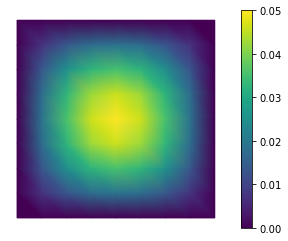

In [35]:
from skfem.visuals.matplotlib import plot, savefig

plot(mesh, x, shading='gouraud', colorbar=True)


9
(81, 3) [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, -1.0, 2.9999999999999996, 1.0, 1.0, 1.0, 1.0, -1.0, 2.9999999999999996, -1.9999999999999998, 4.0, 1.0, 1.0, 1.0, 1.0, -1.9999999999999998, 4.0, -3.0, 5.000000000000001, 1.0, 1.0, 1.0, 1.0, -3.0, 5.000000000000001, -4.000000000000001, 5.999999999999997, 1.0, 1.0, 1.0, 1.0, -4.000000000000001, 5.999999999999997, -4.999999999999997, 6.999999999999997, 1.0, 1.0, 1.0, 1.0, -4.999999999999997, 6.999999999999997, -5.999999999999997, 8.0, 1.0, 1.0, 1.0, 1.0, -5.999999999999997, 8.0, -7.0, -7.0, -7.0, -7.0, -7.0, -7.0, -7.0, -7.0, 0.0, 1.0, 2.0, 2.0, 2.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 0.0, -1.0, 2.0, 0.0, 2.9999999999999996, 2.0, 0.0, -1.0, 0.0, -2.0, 3.0, -0.9999999999999999, 4.0, 2.0, 0.0, -2.0, 0.0, -3.0, 4.0, -2.0, 5.000000000000001, 2.0, 0.0, -3.0, 0.0, -4.0, 5.0, -3.0000000000000013, 5.999999999999999, 2.0, 0.0, -4.0, 0.0, -5.0, 6.0, -3.9999999999999996, 6.999999999999997, 

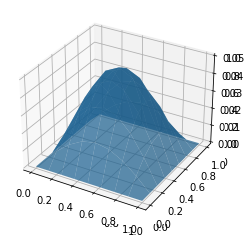

(<Figure size 432x288 with 2 Axes>, <Axes3DSubplot:>)

In [86]:
def plot_decision_boundary(model_plot, steps=9, cmap='Paired'):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    cmap = plt.get_cmap(cmap)
    # steps = 1000
    x_span = np.linspace(0, 1, steps)
    print(len(x_span))
    y_span = np.linspace(0, 1, steps)
    xx, yy = np.meshgrid(x_span, y_span)
    test = np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape[0])]
    test_list = [multiply_init(ar) for ar in test]
    print(test.shape,test_list)
    func_values = model_plot.predict(test_list)
    print(func_values.shape)
    z = func_values.reshape(xx.shape)  # *boundary
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(xx, yy, z, alpha=0.7)
    #ax.contourf(xx, yy, z, alpha=0.7)
    # contourf
    plt.show()
    #plot(mesh,func_values)
    return fig, ax

plot_decision_boundary(new_model)

